In [79]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
import pylab

# Regresión Lineal múltiple

### Ciencia de Datos para físicos: teoría y aplicaciones.

En este notebook veremos como realizar regresión lineal en python con la librería scikit-learn. La cual es una librería de aprendizaje de máquina que contiene una gran cantidad de algoritmos de aprendizaje supervisado y no supervisado. Así como herramientas para preprocesamiento de datos, selección de modelos, evaluación de modelos, etc.

In [27]:
data = pd.read_csv('2c_california_housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [28]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [29]:
data.dropna(inplace=True)

### Algunos plots informativos

recuerda que esta parte es más extensa y corresponde al análisis exploratorio de datos. En este caso, como ya hemos visto en notebooks anteriores, solo mostraremos algunos plots informativos.

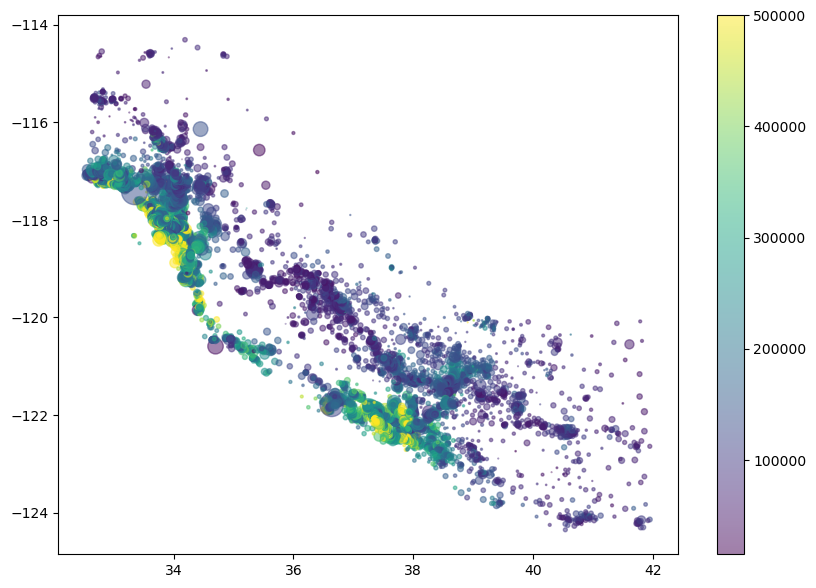

In [30]:
plt.figure(figsize=(10,7))
plt.scatter(data['latitude'], data['longitude'], c=data['median_house_value'], cmap='viridis', 
            alpha=0.5, s=data['population']/100, label='population')
plt.colorbar()
plt.show()

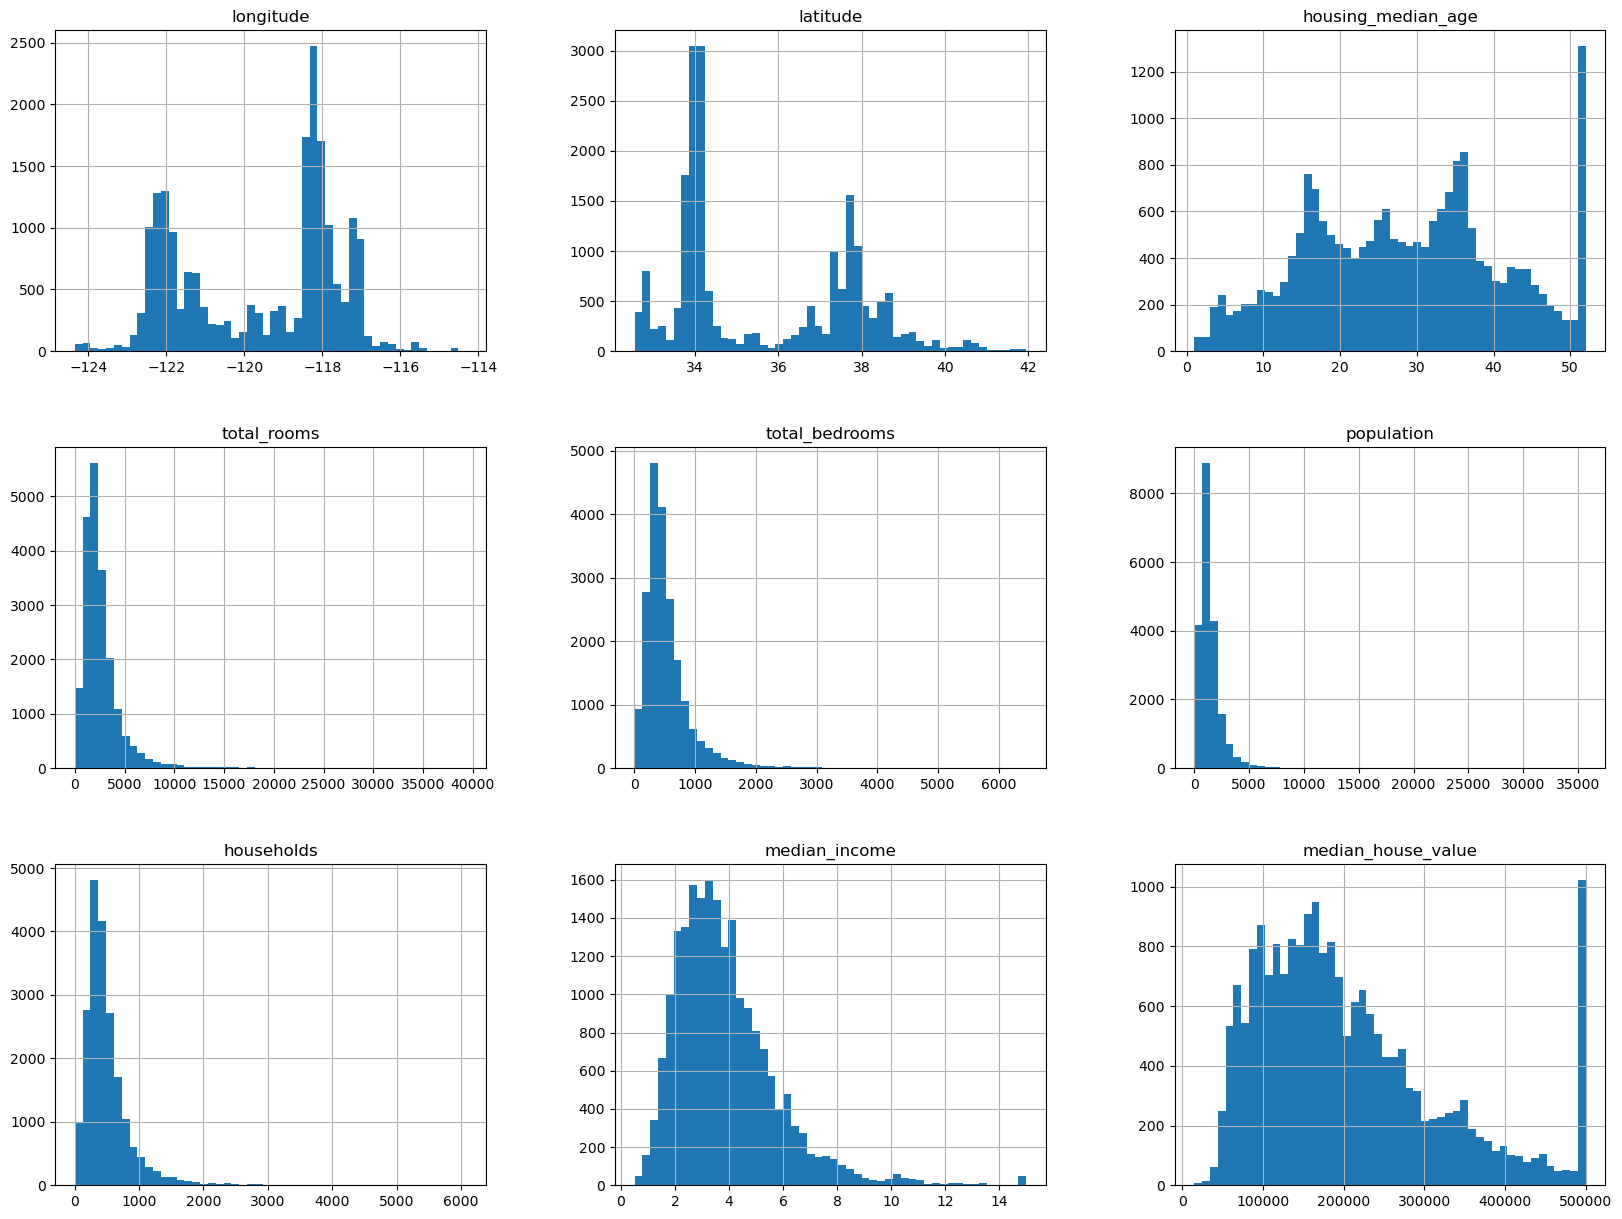

In [31]:
data.hist(bins=50, figsize=(20,15));

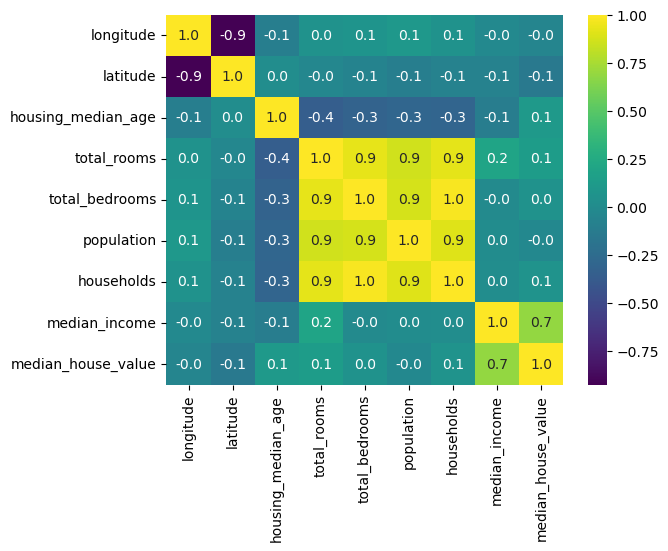

In [32]:
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='viridis', fmt='.1f');

### Agreguemos agregemos columnas extra a los datos

In [33]:
data['rooms_per_house'] = data['total_rooms']/data['households']
data['bedrooms_per_room'] = data['total_bedrooms']/data['total_rooms']
data['population_per_household'] = data['population']/data['households']

In [34]:
# Cuando tenemos campos categoricos, debemos representar de manera numerica
# cada uno de ellos, para ello podemos usar one-hot encoding o bien label encoding
# En este caso usaremos label encoding debido a que son pocas categorias
print(data['ocean_proximity'].unique())

#data.ocean_proximity = data.ocean_proximity.map({'<1H OCEAN':0, 'INLAND':1, 'ISLAND':2, 
#                                                 'NEAR BAY':3, 'NEAR OCEAN':4})

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


### Division en entrenamiento y prueba

In [35]:
# Primero dividimos en variables dependientes e independientes
X = data.drop(['median_house_value'], axis=1)
Y = data['median_house_value']

In [36]:
# Usamos el metodo de sklearn para dividir en train y test
# test_size es el porcentaje de datos que se usaran para test
# Recuerda que casi siempre se usa 80% para train y 20% para test (Regla de Pareto)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [37]:
# Ya casi estamos listos, debemos rellenar los valores nulos o bien eliminarlos
# En este caso usaremos la media para rellenar los valores nulos
# El rellenado de nulos debe realizarse despues de dividir en train y test
# Esto para evitar sesgar los datos de test
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

C:\Users\roker\AppData\Local\Temp\ipykernel_11152\1521245293.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train = X_train.fillna(X_train.mean())
C:\Users\roker\AppData\Local\Temp\ipykernel_11152\1521245293.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_test = X_test.fillna(X_test.mean())


### Escalado de características
Dado que las características de entrada están en diferentes escalas, es importante escalarlas antes de entrenar un modelo. El escalado de características se puede realizar de varias maneras, pero la más común es la estandarización, que consiste en restar la media y dividir por la desviación estándar de cada característica. En scikit-learn, podemos hacer esto usando la clase StandardScaler.

In [38]:
# Podemos escalar las columnas de a una por una, pero eso suele ser muy ineficiente,
# por lo que usaremos un pipeline para escalar todas las columnas a la vez
# Debemos tener cuidado de no escalar las columnas categoricas
# Para ello usaremos ColumnTransformer

# Nos aseguramos de que las columnas categoricas sean tratadas como tal
X_train['ocean_proximity'] = X_train['ocean_proximity'].astype('category')
X_test['ocean_proximity'] = X_test['ocean_proximity'].astype('category')

X_train.dtypes

longitude                    float64
latitude                     float64
housing_median_age           float64
total_rooms                  float64
total_bedrooms               float64
population                   float64
households                   float64
median_income                float64
ocean_proximity             category
rooms_per_house              float64
bedrooms_per_room            float64
population_per_household     float64
dtype: object

### Selección de características

In [39]:
corr = data.corr()
corr['median_house_value'].sort_values(ascending=False)

C:\Users\roker\AppData\Local\Temp\ipykernel_11152\3714763398.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


median_house_value          1.000000
median_income               0.688355
rooms_per_house             0.151344
total_rooms                 0.133294
housing_median_age          0.106432
households                  0.064894
total_bedrooms              0.049686
population_per_household   -0.023639
population                 -0.025300
longitude                  -0.045398
latitude                   -0.144638
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [40]:
# Creamos el pipeline
# Primero creamos un ColumnTransformer para escalar las columnas numericas
# Luego creamos un pipeline para escalar las columnas categoricas
# Finalmente creamos un ColumnTransformer para unir los dos pipelines
# El resultado es un pipeline que escala todas las columnas excepto las categoricas
# y luego las une con las categoricas
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, 
                                                ['median_income', 'rooms_per_house',
                                                 'total_rooms', 'housing_median_age',
                                                 'households'
                                                 ]),
                                            ('cat', categorical_transformer, ['ocean_proximity'])])


In [41]:
# Observemos el resultado
pd.DataFrame(preprocessor.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9
0,0.438412,-0.200545,0.829311,-1.162062,1.040744,1.0,0.0,0.0,0.0,0.0
1,-0.242389,0.224187,-0.738558,0.348657,-0.856152,0.0,1.0,0.0,0.0,0.0
2,-0.108969,-0.126495,0.587350,-0.287435,0.691525,0.0,1.0,0.0,0.0,0.0
3,-0.861168,-1.179305,-0.122742,-0.048901,1.048681,1.0,0.0,0.0,0.0,0.0
4,-0.168986,-0.369948,-0.365632,-0.128412,-0.247664,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
16341,0.820914,0.499051,0.169376,-0.366947,-0.118029,1.0,0.0,0.0,0.0,0.0
16342,0.487838,0.175936,1.495284,-1.877666,1.331760,1.0,0.0,0.0,0.0,0.0
16343,-0.406634,-0.432947,-0.479414,1.064261,-0.358779,1.0,0.0,0.0,0.0,0.0
16344,0.746774,-0.006098,1.436303,-1.321086,1.479914,0.0,0.0,0.0,1.0,0.0


In [42]:
# Guardemos los resultados en variables
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
# Transformemos tambien Y
Y_train_proc = numeric_transformer.fit_transform(Y_train.values.reshape(-1,1))#Y_train.values.reshape(-1,1)
Y_test_proc = numeric_transformer.fit_transform(Y_test.values.reshape(-1,1))#Y_test.values.reshape(-1,1)

In [43]:
# Ahora si, ya podemos entrenar nuestro modelo, pero primero debemos definirlo
# En este caso usaremos un modelo de regresion lineal
# Recuerda que el modelo de regresion lineal es de la forma y = w0 + w1*x1 + w2*x2 + ... + wn*xn
lin = LinearRegression()

In [44]:
# Entrenamos el modelo
lin = lin.fit(X_train_proc, Y_train_proc.ravel())

In [45]:
# Calcula el R^2
print('R^2 en train {}'.format(lin.score(X_train_proc, Y_train_proc)))
print('R^2 en test {}'.format(lin.score(X_test_proc, Y_test_proc)))

R^2 en train 0.6072729513230473
R^2 en test 0.6067003895123317


In [46]:
print('La pendiente es {}'.format(lin.intercept_))
print('Las ordenadas son {}'.format(lin.coef_))

La pendiente es 0.5231651509675789
Las ordenadas son [ 0.65398924  0.05615773 -0.19335412  0.13044808  0.26592469 -0.36744508
 -0.9525101   1.82463285 -0.28637726 -0.2183004 ]


In [47]:
# Podemos predecir para calcular el error
train_pred = lin.predict(X_train_proc)
train_pred

array([ 0.39599446, -0.61466174, -0.4748814 , ...,  0.00159153,
        0.66832516,  0.5080316 ])

In [48]:
mse_train = mean_squared_error(Y_train_proc, train_pred)
rmse_train = np.sqrt(mse_train)
rmse_train

0.6266793826806119

In [49]:
# Ahora para test
test_pred = lin.predict(X_test_proc)
mse = mean_squared_error(Y_test_proc, test_pred)
rmse = np.sqrt(mse)
rmse

0.6271360382625674

### Regresión Lineal a través de SGD

In [50]:
#instancia modelo
lin = SGDRegressor(penalty=None, learning_rate='constant', eta0=3e-4, max_iter=5000,
                   n_iter_no_change=5001).fit(
    X_train_proc, Y_train)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [51]:
lin.score(X_train_proc, Y_train)

0.6066085168066202

In [52]:
print('La pendiente es {}'.format(lin.intercept_))
print('Las ordenadas son {}'.format(lin.coef_))

La pendiente es [223495.04348717]
Las ordenadas son [ 74996.48485067   4921.1237054  -21786.6513655   15670.0603652
  31699.49052919   3268.31517926 -64840.78819151 253226.88403613
  12029.50380314  19811.1286601 ]


In [53]:
def train_SGD(X_train, Y_train, X_test, Y_test, eta0=1e-3, iter=100000):
    model = SGDRegressor(penalty=None, learning_rate='constant', eta0=eta0, max_iter=100000,
                         n_iter_no_change=iter+1)
    loss_train = []
    loss_test = []
    for i in range(iter):
        model.partial_fit(X_train, Y_train)
        loss_train.append(np.sqrt(mean_squared_error(Y_train, model.predict(X_train))))
        loss_test.append(np.sqrt(mean_squared_error(Y_test, model.predict(X_test))))
    del model
    return loss_train, loss_test

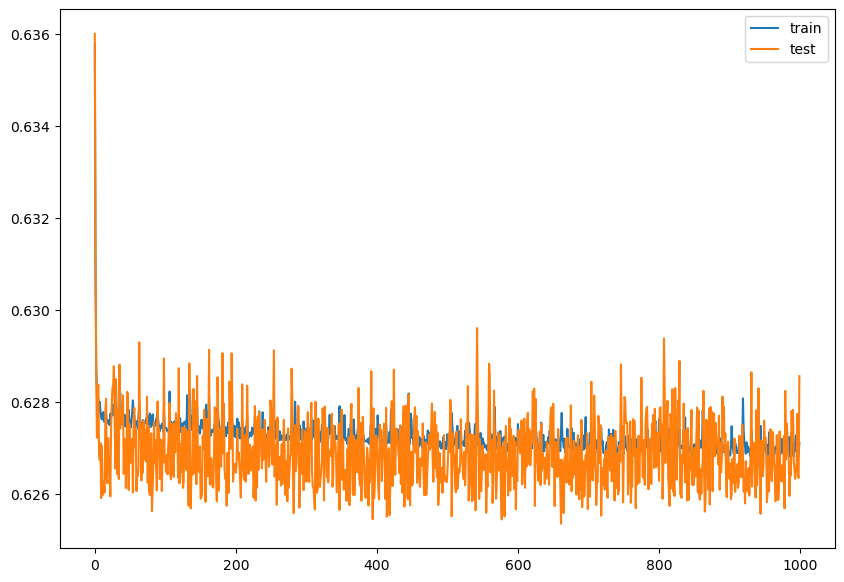

In [54]:
plt.figure(figsize=(10,7))
a,b = train_SGD(X_train_proc, Y_train_proc.ravel(), X_test_proc, Y_test_proc.ravel(), 
                eta0=3e-4, iter=1000)
plt.plot(a, label='train')
plt.plot(b, label='test')
plt.legend();

### Algunas gráficas de los supuestos de la regresión lineal

In [55]:
residuales_train = (Y_train_proc.ravel() - train_pred.ravel())
res_t = {'residuales': residuales_train, 'predicted_val':train_pred, 'tipo': 'train'}
residuales_train = pd.DataFrame(res_t)
residuales_test = (Y_test_proc.ravel() - test_pred.ravel())
res_tr = {'residuales': residuales_test, 'predicted_val':test_pred, 'tipo': 'test'}
residuales_test = pd.DataFrame(res_tr)

residuales = pd.concat([residuales_test,residuales_train])

### Normalidad

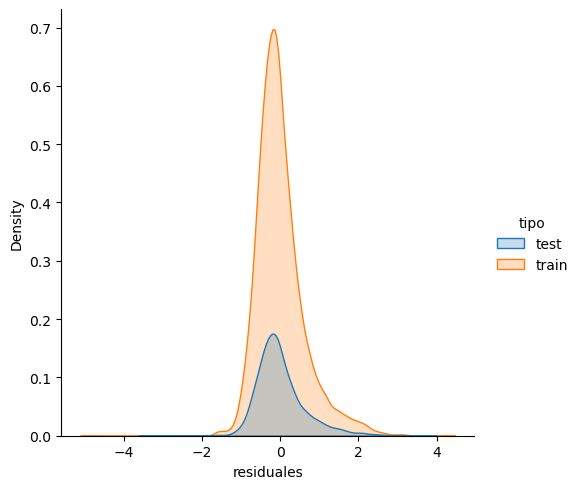

In [56]:
sns.displot(data=residuales, x='residuales', hue='tipo', kind='kde', fill=True);

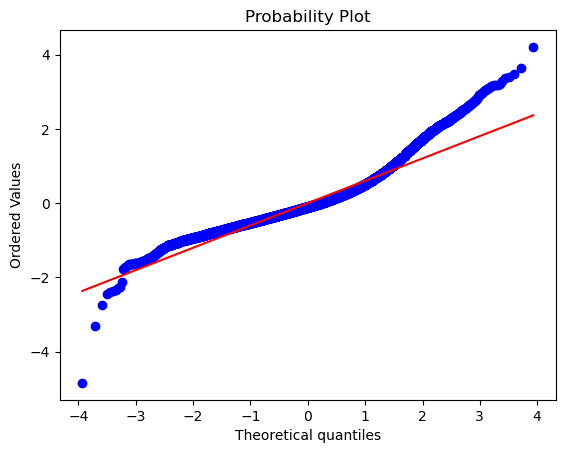

In [57]:
# para entrenamiento
stats.probplot(residuales_train['residuales'], plot=pylab);

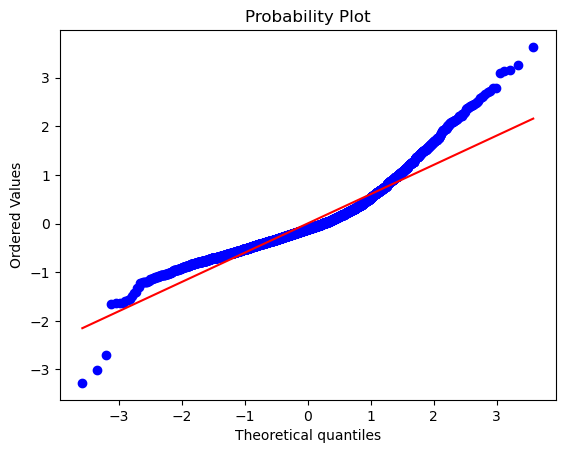

In [58]:
# para test
stats.probplot(residuales_test['residuales'], plot=pylab);

### Homocedasticidad

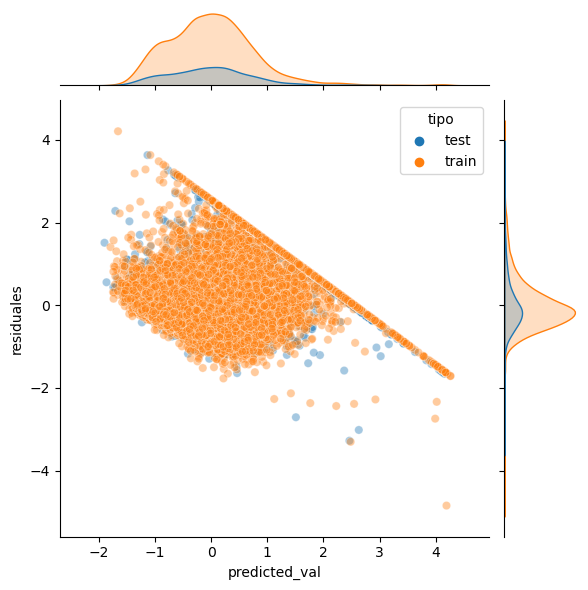

In [59]:
sns.jointplot(data=residuales, x='predicted_val', y='residuales', hue='tipo',
              alpha=0.4)

### No autocorrelación

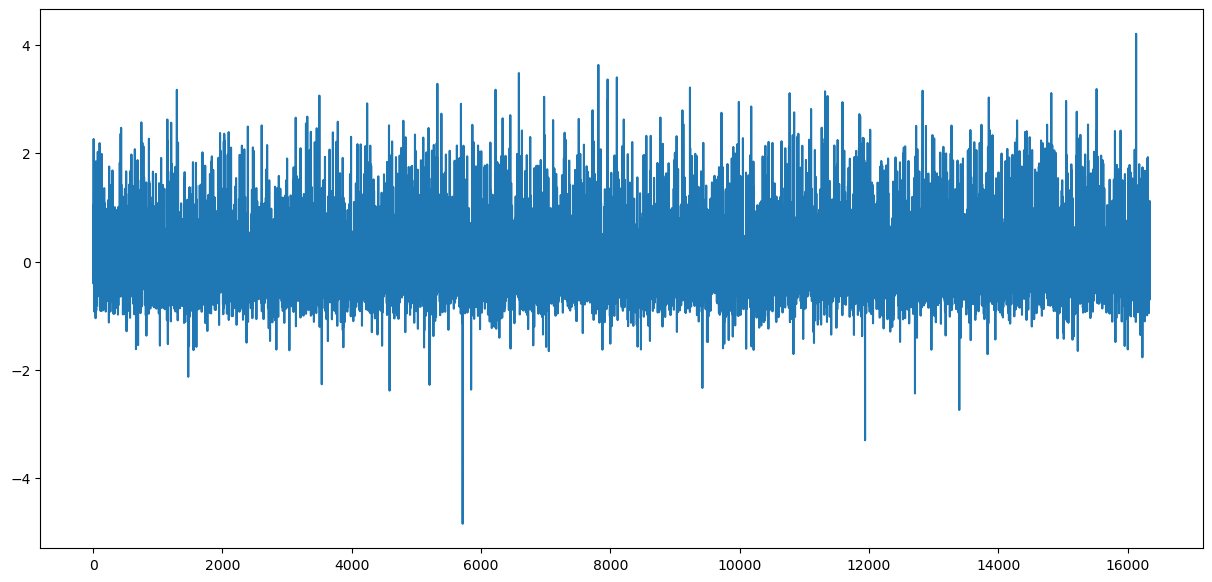

In [60]:
plt.figure(figsize=(15,7))
plt.plot(residuales_train['residuales'])

### Árbol de decisión

In [61]:
regressor = RandomForestRegressor(random_state=0).fit(X_train_proc, Y_train_proc.ravel())

In [72]:
print('"R^2" en train {}'.format(regressor.score(X_train_proc, Y_train_proc)))
print('"R^2" en test {}'.format(regressor.score(X_test_proc, Y_test_proc)))

"R^2" en train 0.9518810489335962
"R^2" en test 0.6550520986563906


In [74]:
#Calcula MSE en train y test
train_pred = regressor.predict(X_train_proc)
mse_train = mean_squared_error(Y_train_proc, train_pred)
rmse_train = np.sqrt(mse_train)
test_pred = regressor.predict(X_test_proc)
mse_test = mean_squared_error(Y_test_proc, test_pred)
rmse_test = np.sqrt(mse_test)

In [75]:
print('RMSE en train {}'.format(rmse_train))
print('RMSE en test {}'.format(rmse_test))

RMSE en train 0.2193603224523612
RMSE en test 0.5873226552276095


In [64]:
reg = RandomForestRegressor(random_state=0, max_depth=8, 
                            n_estimators=250).fit(X_train_proc, Y_train_proc.ravel())

In [76]:
print('"R^2" en train {}'.format(reg.score(X_train_proc, Y_train_proc)))
print('"R^2" en test {}'.format(reg.score(X_test_proc, Y_test_proc)))

"R^2" en train 0.7181975558085295
"R^2" en test 0.6626324123622007


In [77]:
#Calcula MSE en train y test
train_pred = reg.predict(X_train_proc)
mse_train = mean_squared_error(Y_train_proc, train_pred)
rmse_train = np.sqrt(mse_train)
test_pred = reg.predict(X_test_proc)
mse_test = mean_squared_error(Y_test_proc, test_pred)
rmse_test = np.sqrt(mse_test)

In [78]:
print('RMSE en train {}'.format(rmse_train))
print('RMSE en test {}'.format(rmse_test))

RMSE en train 0.5308506797504082
RMSE en test 0.5808335283347539


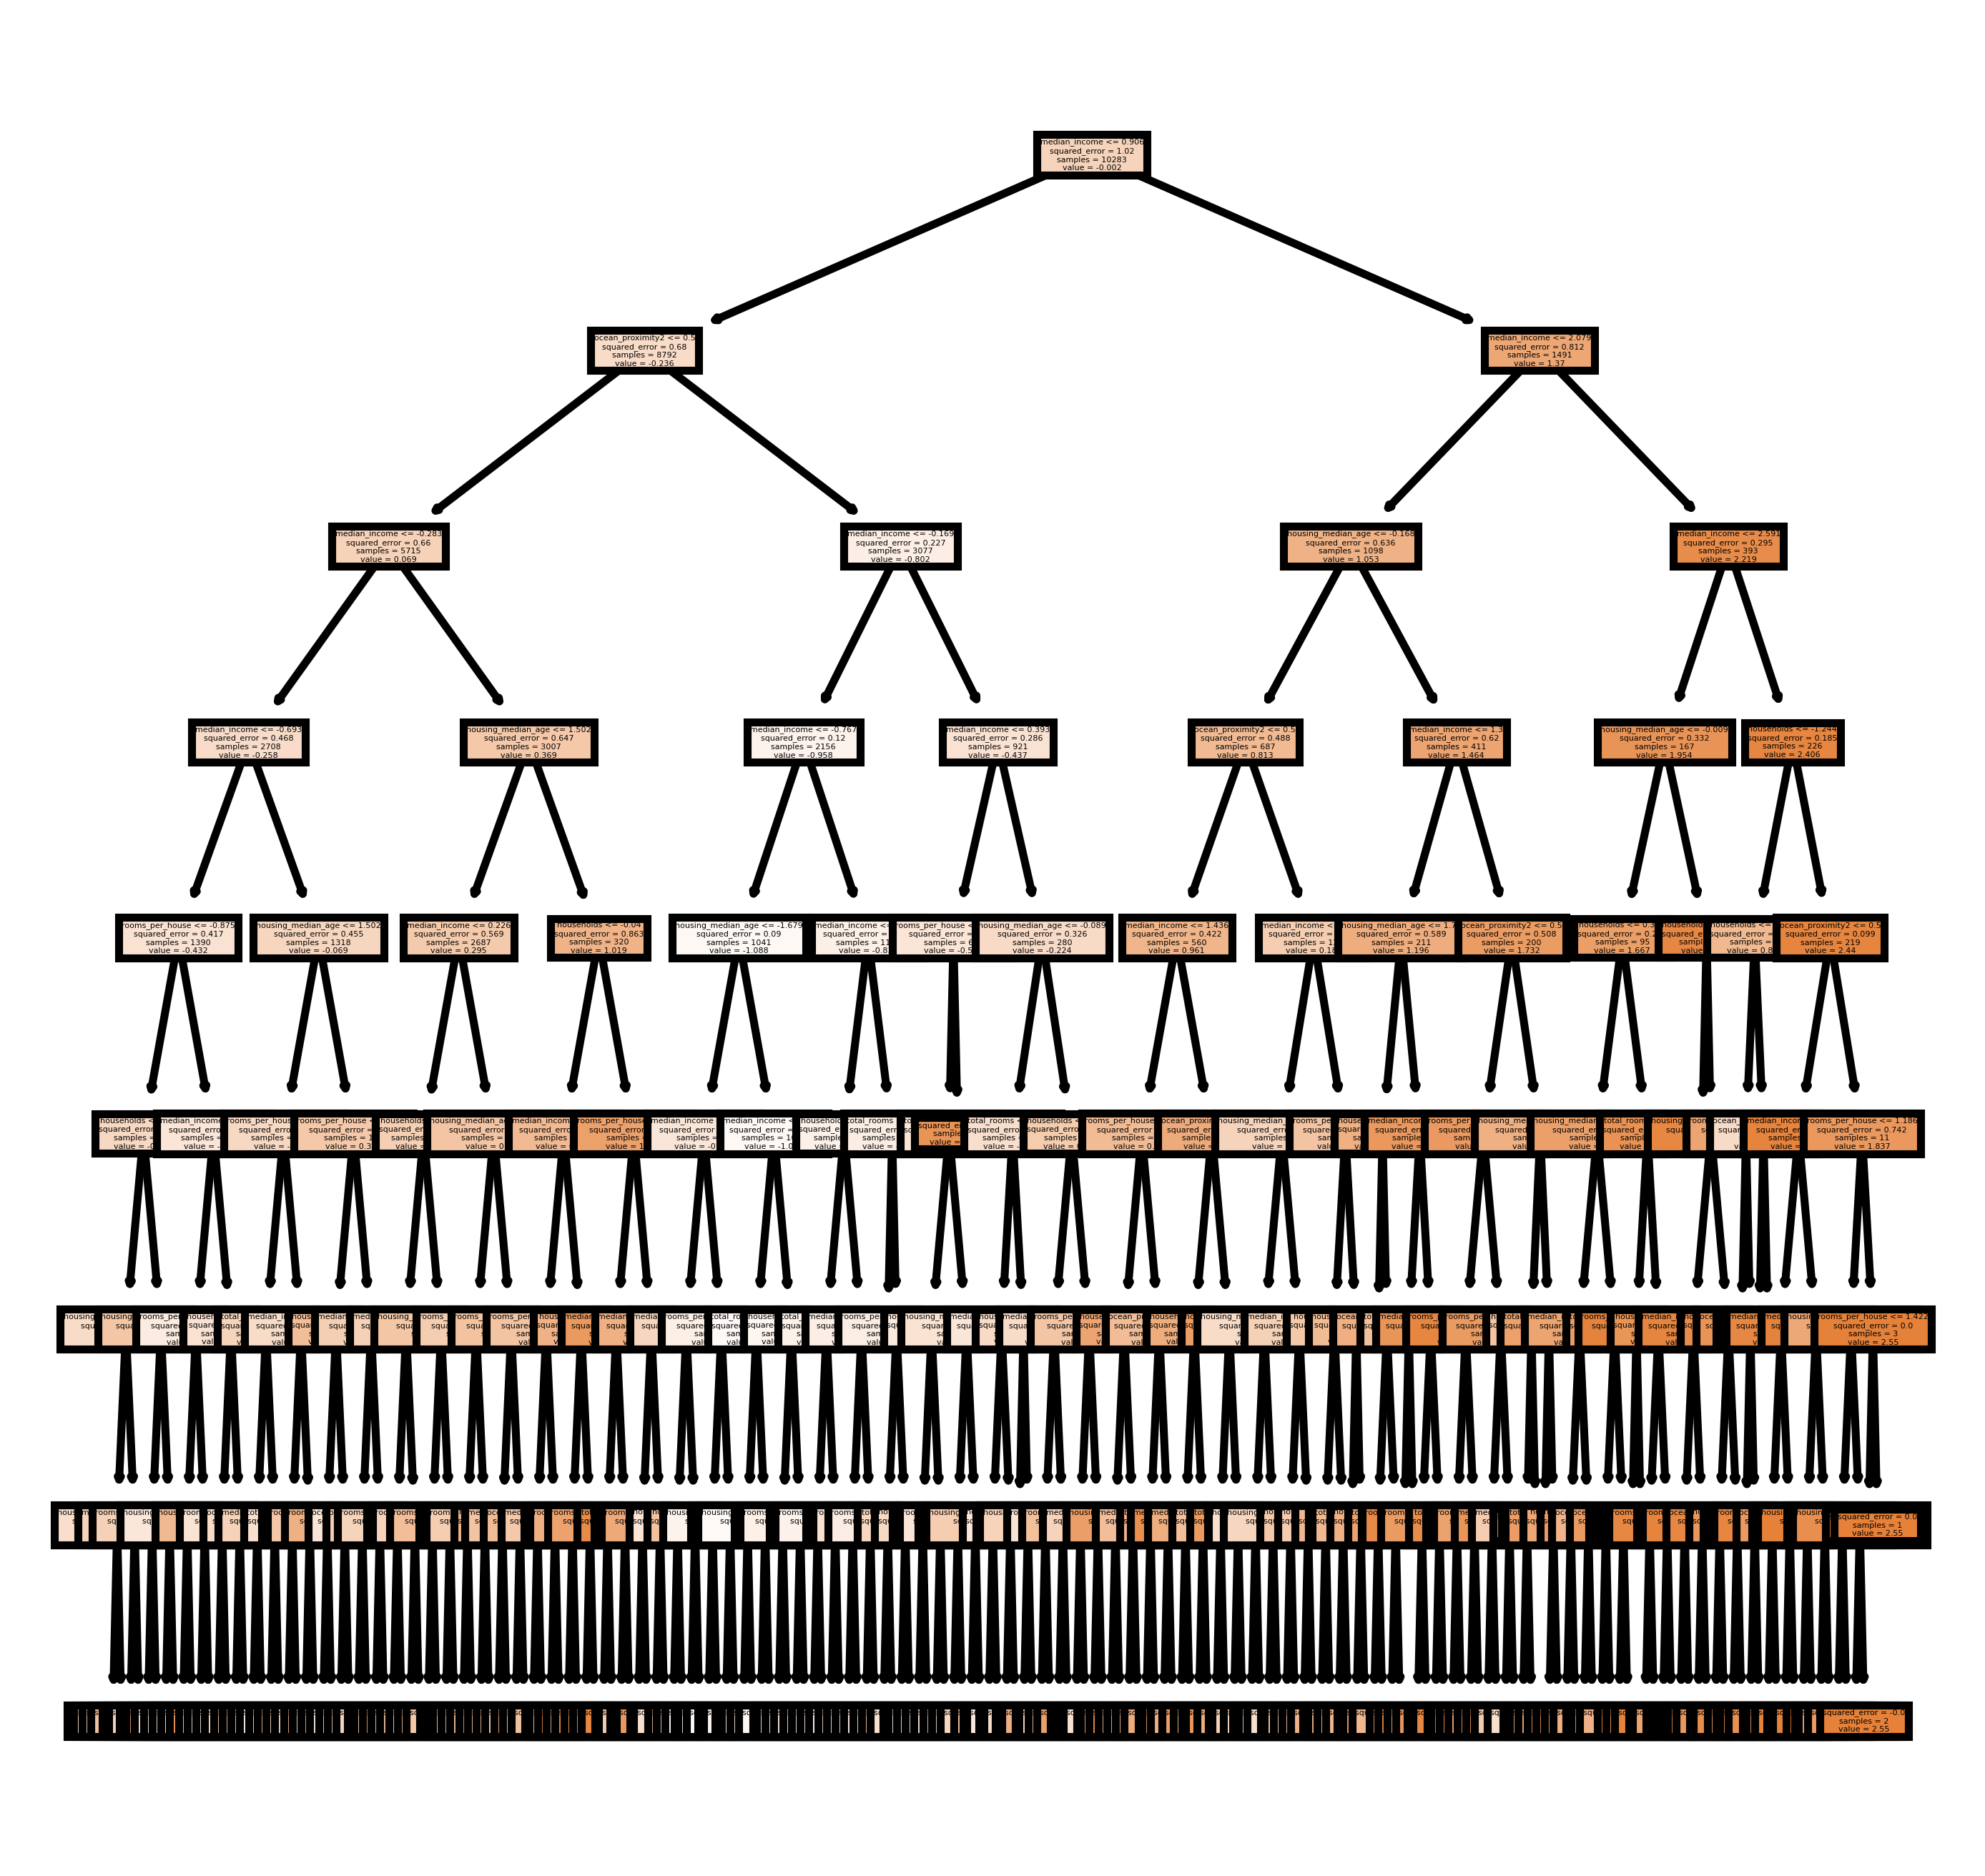

In [92]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(reg.estimators_[0],
               feature_names = ['median_income', 'rooms_per_house',
                                                 'total_rooms', 'housing_median_age',
                                                 'households', 'ocean_proximity1',
                                                 'ocean_proximity2', 'ocean_proximity3',
                                                 'ocean_proximity4', 'ocean_proximity5'], 
               filled = True);